# YOHO training

In [1]:
# Automatically reload modules before entering the execution of code typed at 
# the IPython prompt
%load_ext autoreload
%autoreload 2

In [3]:
# Import used libraries

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import librosa
import torch


torch.manual_seed(0)

print(f"{pd.__name__} version: {pd.__version__}")
print(f"{matplotlib.__name__} version: {matplotlib.__version__}")
print(f"{librosa.__name__} version: {librosa.__version__}")
print(f"{torch.__name__} version: {torch.__version__}")


from yoho24.utils import AudioClip, AudioFile, TUTDataset, YOHODataGenerator

pandas version: 2.1.2
matplotlib version: 3.8.3
librosa version: 0.10.2.post1
torch version: 2.4.0


In [4]:
def plot_melspectrogram(
    audio: AudioFile,
    n_mels: int = 40,
    win_len: float = 1.00,
    hop_len: float = 1.00,
):
    """
    Plots the Mel spectrogram.
    """
    plt.figure(figsize=(10, 4))
    plt.title(f"Mel spectrogram")
    librosa.display.specshow(
        data=audio.mel_spectrogram(
            n_mels=n_mels, win_len=win_len, hop_len=hop_len
        ),
        sr=audio.sr,
        x_axis="frames",
        y_axis="mel",
    )
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

## Data generator

In [5]:
N_MELS = 40
WIN_S = 0.04 # 40 ms
HOP_S = 0.01 # 10 ms

In [6]:
audios = [
    AudioFile(filepath=file.filepath, labels=eval(file.events))
    for _, file in pd.read_csv(
        "./data/processed/TUT/TUT-sound-events-2017-development.csv"
    ).iterrows()
]

audioclips = [
    audioclip
    for _, audio in enumerate(audios)
    for audioclip in audio.subdivide(win_len=2.56, hop_len=1.96)
    if _ < 1
]

In [7]:
N_MELS = 40
HOP_MS = 10
WIN_MS = 40

tut_train = TUTDataset(
    audios=audioclips,
)

print(f"Number of audio files: {len(tut_train)}")
print(f"Duration: {tut_train.audios[0].duration} seconds")
print(f"Sampling rate: {tut_train.audios[0].sr} Hz")

Number of audio files: 122
Duration: 2.56 seconds
Sampling rate: 44100 Hz


In [8]:
train_dataloader = YOHODataGenerator(tut_train, batch_size=4, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))

print(f"Train features shape: {train_features.shape}")
print(f"Train labels shape: {train_labels.shape}")

Train features shape: torch.Size([4, 1, 40, 257])
Train labels shape: torch.Size([4, 18, 9])


In [9]:
from yoho24.yoho import YOHO

random_input = torch.randn(4, 1, 64, 801)

model = YOHO(input_shape=(4, 1, 64, 801), n_classes=2)
x = model(random_input)
print(x.shape)

random_input2 = torch.randn(8, 1, 40, 257)

model2 = YOHO(input_shape=(8, 1, 40, 257), n_classes=6)
x2 = model2(random_input2)
print(x2.shape)

torch.Size([4, 6, 26])
torch.Size([8, 18, 9])


In [10]:
from torchsummary import summary

summary(
    YOHO(input_shape=(4, 1, 64, 801), n_classes=2),
    input_size=(1, 64, 801),
    batch_size=4,
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 32, 32, 401]             288
       BatchNorm2d-2           [4, 32, 32, 401]              64
              ReLU-3           [4, 32, 32, 401]               0
            Conv2d-4           [4, 32, 32, 401]             288
       BatchNorm2d-5           [4, 32, 32, 401]              64
              ReLU-6           [4, 32, 32, 401]               0
            Conv2d-7           [4, 64, 32, 401]           2,112
       BatchNorm2d-8           [4, 64, 32, 401]             128
              ReLU-9           [4, 64, 32, 401]               0
          Dropout-10           [4, 64, 32, 401]               0
DepthwiseSeparableConv-11           [4, 64, 32, 401]               0
           Conv2d-12           [4, 64, 16, 201]             576
      BatchNorm2d-13           [4, 64, 16, 201]             128
             ReLU-14           [4,

In [18]:
from torchvision.transforms import v2
from torchaudio.transforms import TimeMasking, FrequencyMasking

transforms = v2.Compose([
    TimeMasking(time_mask_param=25),
    TimeMasking(time_mask_param=25),
    FrequencyMasking(freq_mask_param=8),
])

time_masking = TimeMasking(time_mask_param=25)
freq_masking = FrequencyMasking(freq_mask_param=8)

spec = train_features[0]

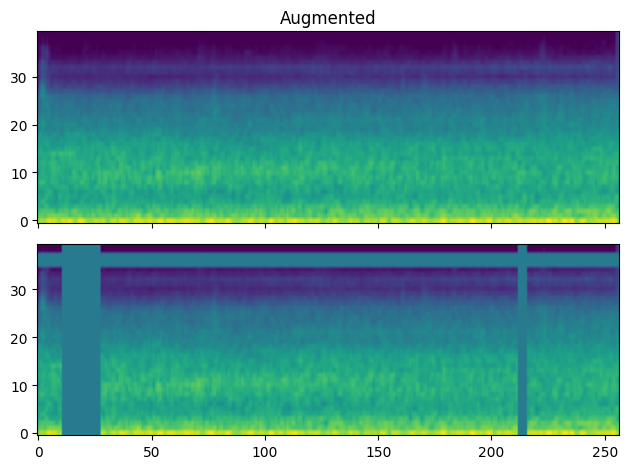

In [50]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
ax[0].set_title("Original")
ax[0].imshow(spec[0], origin="lower", aspect="auto")
ax[0].set_title("Augmented")
ax[1].imshow(transforms(spec)[0], origin="lower", aspect="auto")
fig.tight_layout()

## Training

In [63]:
import os
import torch
import pandas as pd
from yoho24.utils import AudioFile, TUTDataset, YOHODataGenerator
from torchvision.transforms import v2
from torchaudio.transforms import TimeMasking, FrequencyMasking
SCRIPT_DIRPATH = os.getcwd() + "/yoho24"

In [69]:
# Device configuration
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()

In [64]:
training_audioclips = [
        audioclip
        for _, file in pd.read_csv(
            os.path.join(
                SCRIPT_DIRPATH,
                "../data/processed/TUT/TUT-sound-events-2017-development.csv",
            )
        ).iterrows()
        for audioclip in AudioFile(
            filepath=file.filepath, labels=eval(file.events)
        ).subdivide(win_len=2.56, hop_len=1.96)
]

evaluation_audioclips = [
    audioclip
    for _, file in pd.read_csv(
        os.path.join(
            SCRIPT_DIRPATH,
            "../data/processed/TUT/TUT-sound-events-2017-evaluation.csv",
        )
    ).iterrows()
    for audioclip in AudioFile(
        filepath=file.filepath, labels=eval(file.events)
    ).subdivide(win_len=2.56, hop_len=1.96)
]

In [65]:
torch.manual_seed(0)

# Define the transforms
transforms = v2.Compose(
    [
        TimeMasking(time_mask_param=25),
        TimeMasking(time_mask_param=25),
        FrequencyMasking(freq_mask_param=8),
    ]
)

# Define the data generators
train_dataloader = YOHODataGenerator(
        dataset=TUTDataset(
            audios=training_audioclips,
            transform=transforms,
        ),
        batch_size=32,
        shuffle=True,
    )

eval_dataloader = YOHODataGenerator(
    dataset=TUTDataset(audios=evaluation_audioclips),
    batch_size=32,
    shuffle=False,
)

In [ ]:
from yoho24.train import load_checkpoint, train_model

In [67]:
from yoho24.yoho import YOHO

# Define the model
model = YOHO(input_shape=(1, 40, 257), n_classes=6).to(device)

# Get the optimizer
optimizer = model.get_optimizer()

# Load the model checkpoint if it exists
model, optimizer, start_epoch, _ = train.load_checkpoint(model, optimizer)

EPOCHS = 60
train_model(
        model=model,
        train_loader=train_dataloader,
        val_loader=eval_dataloader,
        num_epochs=EPOCHS,
        start_epoch=start_epoch,
    )

In [ ]:
# to load
checkpoint = torch.load('filename.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])